# Overall description

In [ ]:
# This is an 3D example code based on SimPEG package.
# All cases are designed for on-land survey using 
# feequency domain CSEM method, with a line source.

# Author: Zhuo Liu, Colorado School of Mines
# Created in May, 2020

# Import packages

In [42]:
import math as m
import numpy as np
import SimPEG as spg
from SimPEG import EM, Utils
import pyvista as pv
from pymatsolver import Pardiso
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

#%matplotlib notebook    # Activate interactivity of figures with backend
import matplotlib
matplotlib.rcParams['figure.figsize'] = [14, 9]    # Set length and height of the canvas
#matplotlib.rcParams['figure.subplot.left'] = 0
#matplotlib.rcParams['figure.subplot.bottom'] = 0
#matplotlib.rcParams['figure.subplot.right'] = 1
#matplotlib.rcParams['figure.subplot.top'] = 1


# Define functions

In [4]:
# Self defined fucntions, for a succinct code and versatility

# Define function to construct anomalous bodies
def ModelConstruct3D(mesh, physivalue, x_bound, y_bound, z_bound):
    '''
    Input: mesh: the mesh created for modeling, SimPEG.Mesh;
           physivalue: Physical property values, 1D array;
           x_bound: Boundary of each region in x-direction, 1D array or list.
                    organized as [x1start, x1end, x2start, x2end...]
           y_bound: Boundary of each region in y-direction, 1D array or list.
                    organized as [y1start, y1end, y2start, y2end...]
           z_bound: Boundary of each region in z-direction, 1D array or list.
                    organized as [y1start, y1end, y2start, y2end...]
    
    Tip: 1. All inputs should be organized in an order from large-region to small-region;
         2. All bound values should be organized in an order from lower value to highre value.
    
    Output: model: the model, array
    '''
    
    nvalue = len(physivalue)
    
    model = np.ones(mesh.nC)    # Initialize model vector
    
    for i in range(nvalue):
        index = (
            (mesh.gridCC[:, 0]>=x_bound[2*i]) & (mesh.gridCC[:, 0]<=x_bound[2*i+1]) &
            (mesh.gridCC[:, 1]>=y_bound[2*i]) & (mesh.gridCC[:, 1]<=y_bound[2*i+1]) &
            (mesh.gridCC[:, 2]>=z_bound[2*i]) & (mesh.gridCC[:, 2]<=z_bound[2*i+1])
        )

        model[index] = physivalue[i]    #Set rock-background

    return model






# Define constants

In [37]:
# Set invariables

# Set constant
u = 4 * m.pi * 10**(-7)


# Set forward model

<Figure size 1008x648 with 0 Axes>

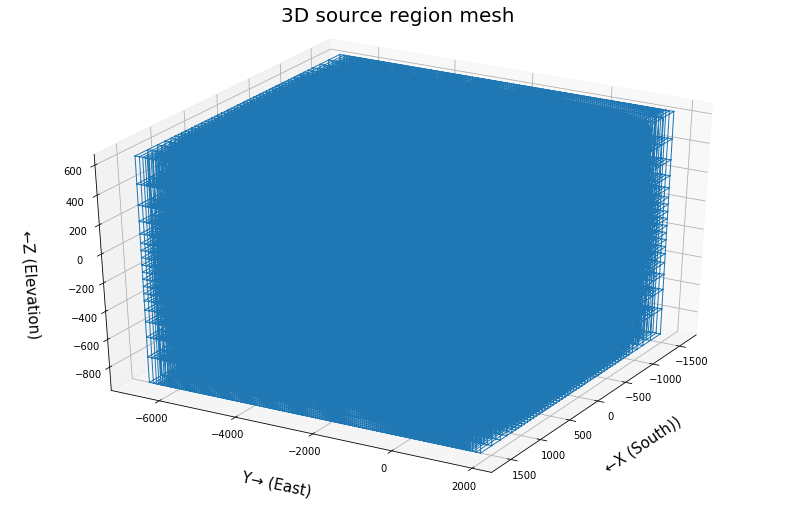

There are 149400 cells in the mesh


In [7]:
# Set model space and value

# Set the length of core region in 3 directions
core_x_dir, core_y_dir, core_z_dir = 2000, 8000, 400    # Unit in meter    

# cell widths in the core region of the mesh
hx, hy, hz = 50, 50, 50    # Unit in meter

# Number of the core cells
n_core_x, n_core_y, n_core_z = int(core_x_dir/hx), int(core_y_dir/hy), int(core_z_dir/hz)

# Number of padding cells in each dimension
npadx, npady, npadz = 5, 3, 5

# Padding factor
pad_factor = 1.3

# Make meshed space
mesh = spg.Mesh.TensorMesh([
    [(hx, npadx, -pad_factor), (hx, n_core_x), (hx, npadx, pad_factor)],
    [(hy, npady, -pad_factor), (hy, n_core_y), (hy, npady, pad_factor)],
    [(hz, npadz, -pad_factor), (hz, n_core_z), (hz, npadz, pad_factor)]
])

# Set the center of the mesh
mesh.x0 = np.r_[
    -(mesh.hx[0:npadx+int(0.5*n_core_x)].sum()),    # Set zeor in x-direction to the middle
    -(mesh.hy[0:npady+int(0.8*n_core_y)].sum()),    # Set zero in y-direction to the top
    -(mesh.hz[0:npadz+n_core_z-1].sum())    # Set zero in y-direction below one layer of core region
]

# Plot the mesh and print the number of cells
meshfig = plt.figure(1)
meshplot = mesh.plotGrid()
plt.title('3D source region mesh\n', fontsize=20, loc='center')
meshplot.set_xlabel('\n\n\n ←X (South))', fontsize=15)
meshplot.set_ylabel('\n\n\n Y→ (East)', fontsize=15)
meshplot.set_zlabel('\n\n\n ←Z (Elevation)', fontsize=15)
meshplot.view_init(32, 30)    # Set view angle, make it clear that we use right-handed coordinate system.
plt.show()
print(f"There are {mesh.nC} cells in the mesh")



<Figure size 1008x648 with 0 Axes>

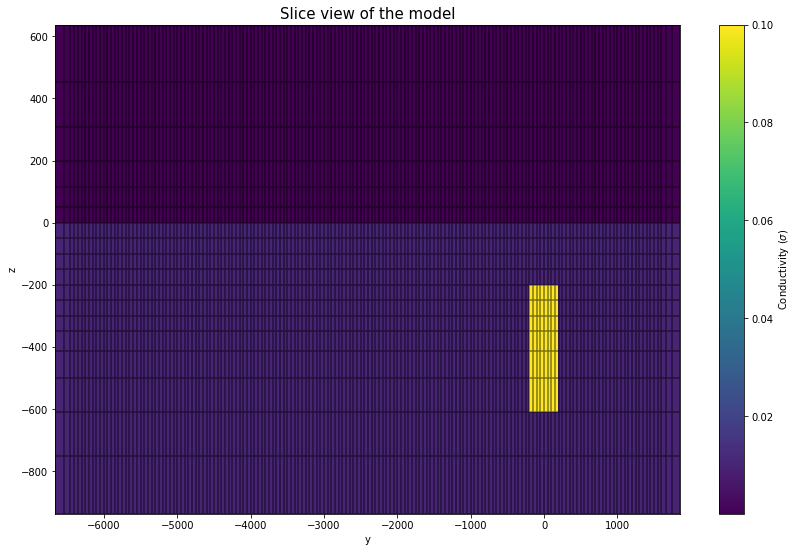

In [12]:
# Incorporate model value into the mesh
sigma_list = np.r_[1e-8, 0.01, 0.1]    # Conductivity for air whole space, host-rock half space, and anomalous block

x_bound=[mesh.gridFx.min(), mesh.gridFx.max(),
         mesh.gridFx.min(), mesh.gridFx.max(),
         -200, 200         
         ] 
y_bound=[mesh.gridFy.min(), mesh.gridFy.max(),
         mesh.gridFy.min(), mesh.gridFy.max(),
         -200, 200] 
z_bound=[0, mesh.gridFz.max(),  
         mesh.gridFz.min(), 0,
         -600, -200
         ]

# Fill the meshed space with model values
sigma = ModelConstruct3D(mesh, sigma_list, x_bound, y_bound, z_bound)    # Fill model values to the mesh

# Plot the model, slice view
modelfig = plt.figure(2)
modelplot = mesh.plotSlice(sigma, normal='x', grid=True)
plt.title('Slice view of the model', fontsize=15)
bar2 = plt.colorbar(modelplot[0], label='Conductivity $(\\sigma)$')
plt.show()



# Set up survey

In [9]:
# Set up survey geometry

# Source parameters
# For line source, use solenoid to approximate. Place solenoid on the cell edge.
src_x_lim = [-500, 500]
src_loc_x = mesh.vectorNx[(mesh.vectorNx>=src_x_lim[0]) & (mesh.vectorNx<=src_x_lim[1])]    # Station location in x-direction
src_loc_y = np.r_[-6000]    # Station location in y-direction
src_loc_z = np.r_[0]    # Station location in z-direction
freq = np.r_[10]    # Source frequency in Hz

src_locs = spg.Utils.ndgrid([src_loc_x, src_loc_y, src_loc_z])    # Sourrce coordinates
src_index = spg.Utils.closestPoints(mesh, src_locs)[1:]    # [1:] is needed to drop the first point outside of the ssrc_x_lim
src_vec = np.zeros(mesh.nE)
src_vec[src_index] = 1.    # Source vector, 1 means that edge is a source

# Receiver parameters
rx_loc_x = np.linspace(-1000,1000, 21)
rx_loc_y = np.linspace(-1000,1000, 21)
rx_loc_z = np.r_[0]

rx_locs = spg.Utils.ndgrid(rx_loc_x, rx_loc_y, rx_loc_z)    # Receiver coordinates

# Set up the survey problem
rx_e_real = spg.EM.FDEM.Rx.Point_e(rx_locs, orientation="x",component='real')
rx_e_imag = spg.EM.FDEM.Rx.Point_e(rx_locs, orientation="x",component='imag')
rx_e = [rx_e_real, rx_e_imag]

#rx_b_real = spg.EM.FDEM.Rx.Point_b(rx_locs, orientation="y",component='real')
#rx_b_imag = spg.EM.FDEM.Rx.Point_b(rx_locs, orientation="y",component='imag')
#rx_b = [rx_b_real, rx_b_imag]

# Setup source, approximate line souce by RawVec
srcList_e = [spg.EM.FDEM.Src.RawVec_e(rx_e, freq, src_vec)]    # Approximation of line source. Will change
#srcList_b = [spg.EM.FDEM.Src.RawVec_e(rx_b, freq, src_vec)]    # Approximation of line source. Will change


# Calculate skin depth
skin_depth = 500./np.sqrt(sigma_list * freq)
print('Skin depths is between {:10.2} m and {:10.2} m' .format(skin_depth.min(), skin_depth.max()))



Skin depths is between      5e+02 m and    1.6e+06 m


In [10]:
# Set up survey and problem pair

# Define EM problem
survey_e = spg.EM.FDEM.Survey(srcList_e)
#wires = spg.Maps.Wires(('sigma', mesh.nC))    # Wire maps are needed when the model is comprised of two or more parameter types
                                              # More info please go https://docs.simpeg.xyz/content/tutorials/models_mapping/plot_1_tensor_models.html#sphx-glr-content-tutorials-models-mapping-plot-1-tensor-models-py
prob_e = spg.EM.FDEM.Problem3D_e(mesh, sigmaMap = sigma,
                                 Solver=Pardiso, verbose=True)
prob_e.pair(survey_e)

#survey_b = spg.EM.FDEM.Survey(srcList_b)
#wires = spg.Maps.Wires(('sigma', mesh.nC))    # Wire maps are needed when the model is comprised of two or more parameter types
#                                              # More info please go https://docs.simpeg.xyz/content/tutorials/models_mapping/plot_1_tensor_models.html#sphx-glr-content-tutorials-models-mapping-plot-1-tensor-models-py

#prob_b = spg.EM.FDEM.Problem3D_b(mesh, sigma = sigma, 
#                               Solver=Pardiso, verbose=True)

#prob_b.pair(survey_b)



<Figure size 1008x648 with 0 Axes>

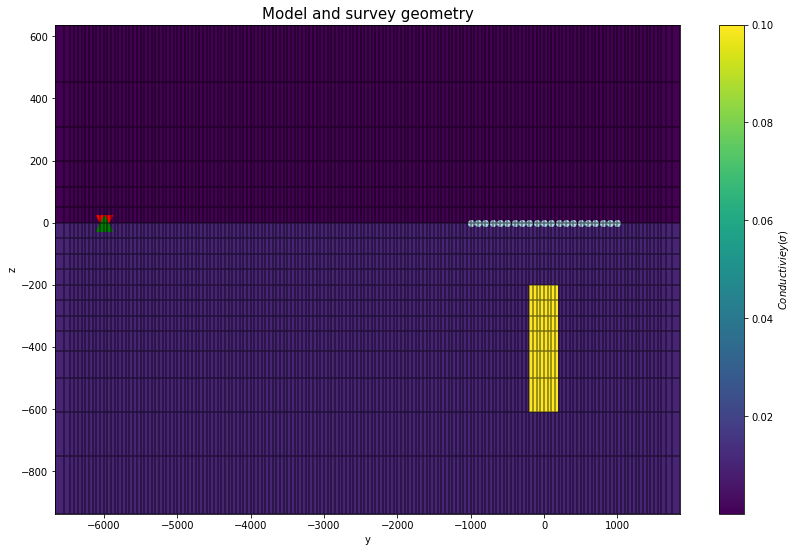

In [15]:
# Plot the problem and survey

# 2D slice plot of the survey and model
surveyfig = plt.figure(3)
modelplot = mesh.plotSlice(sigma, normal='x', grid=True)
plt.title('Model and survey geometry', fontsize=15)
Rxlot = plt.scatter(rx_loc_x, rx_loc_z*np.ones_like(rx_loc_x), c='lightblue')
TxAlot = plt.scatter(src_loc_y, src_loc_z, marker='v', s=250, c='red')
TxBlot = plt.scatter(src_loc_y, src_loc_z, marker='^', s=250, c='green')
bar3 = plt.colorbar(modelplot[0], label="$Conductiviey (\\sigma)$")
plt.show()




# 3D plot of the survey and model

# Calculate field and data

In [44]:
# Calculate EM response

# Calculate fields
e_field = prob_e.fields(sigma)    # Electric
#b_field = prob_b.fields(sigma)    # Magnetic

# Calculate electric data and magnetic data
e_data = survey_e.dpred(sigma, f=e_field)    # Electric
#b_data = survey_b.dpred(sigma, f=b_field)    # Magnetic


# Plot results

In [41]:
# Plot fields
#Fieldfig = plt.figure(4)


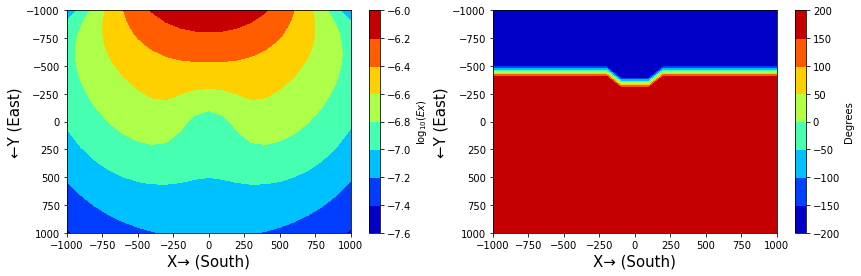

In [45]:
# Plot Data

# Separate real and imaginary parts
e_data_real = e_data[0:len(rx_locs)]    # Electric 
e_data_imag = e_data[len(rx_locs):]
#b_data_real = b_data[0:len(rx_loc_x)]    # Magnetic 
#b_data_imag = b_data[len(rx_loc_x):]

# Calculate data amplitude and phase
e_amp = np.sqrt(e_data_real**2 + e_data_imag**2)    # Electric 
e_phase = np.arctan2(e_data_imag, e_data_real)
#b_amp = np.sqrt(b_data_real**2 + b_data_imag**2)    # Magnetic
#b_phase = np.arctan2(b_data_imag, b_data_real)


Datafig = plt.figure(5)
if len(rx_loc_x) or len(rx_loc_y) != 1:
    # Reorganize results for plotting
    e_amp = np.reshape(e_amp, (len(rx_loc_x), len(rx_loc_y)))
    e_phase = np.reshape(e_phase, (len(rx_loc_x), len(rx_loc_y)))

    
    # Plot results 
    eplot1 = plt.subplot(221)
    e_amp_plot = eplot1.contourf(rx_loc_x, np.flip(rx_loc_y), np.log10(e_amp), cmap='jet')
    eplot1.set_ylabel('←Y (East)', fontsize='15')
    eplot1.set_xlabel('X→ (South)', fontsize='15')
    plt.gca().invert_yaxis()
    bar_5221 = plt.colorbar(e_amp_plot, label='$\log_{10}(Ex)$')
    
    eplot2 = plt.subplot(222)
    e_phase_plot = eplot2.contourf(rx_loc_x, np.flip(rx_loc_y), np.degrees(e_phase), cmap='jet')
    eplot2.set_ylabel('←Y (East)', fontsize='15')
    eplot2.set_xlabel('X→ (South)', fontsize='15')  
    plt.gca().invert_yaxis()
    bar_5222 = plt.colorbar(e_phase_plot, label='Degrees')
    
    #bplot1 = plt.subplot(223)
    #b_amp_plot = bplot1.contourf(rx_loc_x, np.flip(rx_loc_y), np.log10(b_amp), cmap='jet')
    #bplot1.set_ylabel('←Y (East)', fontsize='15')
    #bplot1.set_xlabel('X→ (South)', fontsize='15')
    #plt.gca().invert_yaxis()
    #bar_5225 = plt.colorbar(b_amp_plot, label='$\log_{10}(Hy)$')
    
    #eplot2 = plt.subplot(223)
    #b_phase_plot = bplot2.contourf(rx_loc_x, np.flip(rx_loc_y), np.degrees(b_phase), cmap='jet')
    #bplot2.set_ylabel('←Y (East)', fontsize='15')
    #bplot2.set_xlabel('X→ (South)', fontsize='15')  
    #plt.gca().invert_yaxis()
    #bar_5224 = plt.colorbar(b_phase_plot, label='Degrees')
    
    plt.show()   
    
    
else:
    e_amp = np.sqrt(e_data_real**2 + e_data_imag**2)    # Electric 
    e_phase = np.arctan2(e_data_imag, e_data_real)

    eplot = plt.subplot(111)
    eplot.semilogy(rx_loc_x, (e_amp), label='Ez Amplitude', linewidth=5)
    #eplot.plot(rx_loc_x, np.degrees(e_phase), marker='.', label='Phase (degree)')
    eplot.set_ylabel('Ez Ampliture (V/m)', fontsize='15')
    eplot.set_xlabel('Rx location', fontsize='15')
    plt.legend(fontsize='xx-large')

    #bplot = plt.subplot(122)
    #bplot.plot(rx_loc_x, np.log10(b_amp), label='Amplitude', linewidth=5)
    #bplot.plot(rx_loc_x, np.degrees(b_phase), marker='.', label='Phase (degree)')

    plt.legend(fontsize='xx-large')
    plt.show()
    
 
    

In [465]:
# Plot apparent resistivity

#rhoapp_plot = plt.figure(6)
#plt.plot(rx_loc_x, (e_data_real/b_data_real)**-1, label='app resis', linewidth=5)
#plt.legend(fontsize='xx-large')
#plt.show()